# Distillation

Обучаем сеть, похожую на VGG на задачу классификации CIFAR-10

После этого дистиллируем её в сеть поменьше

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

## Dataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 128

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:02<00:00, 84952149.86it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

def get_cifar_class(class_id):
    cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                     'dog', 'frog', 'horse', 'ship', 'truck']
    
    if class_id >= 0 and class_id < len(cifar_classes):
        return cifar_classes[class_id]
    else:
        return "Invalid class ID"

def tensor_to_numpy(image):
    image = image / 2 + 0.5
    image = np.transpose(image.numpy(), (1, 2, 0)) 
    return image


def plot_image(image, label=None):
    plt.imshow(tensor_to_numpy(image))
    if label is not None:
        plt.title(label)
    plt.axis('off')
    plt.show()


def plot_cifar_loader(loader, title=None, shape=(2, 8)):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    fig, axes = plt.subplots(*shape, figsize=(12, 6))
    axes = axes.flatten()
    for i in range(len(axes)):
        label = labels[i].item()

        axes[i].imshow(tensor_to_numpy(images[i]))
        axes[i].set_title(get_cifar_class(label))
        axes[i].axis('off')

    plt.tight_layout()
    if title is not None:
        fig.suptitle(title)
    plt.show()


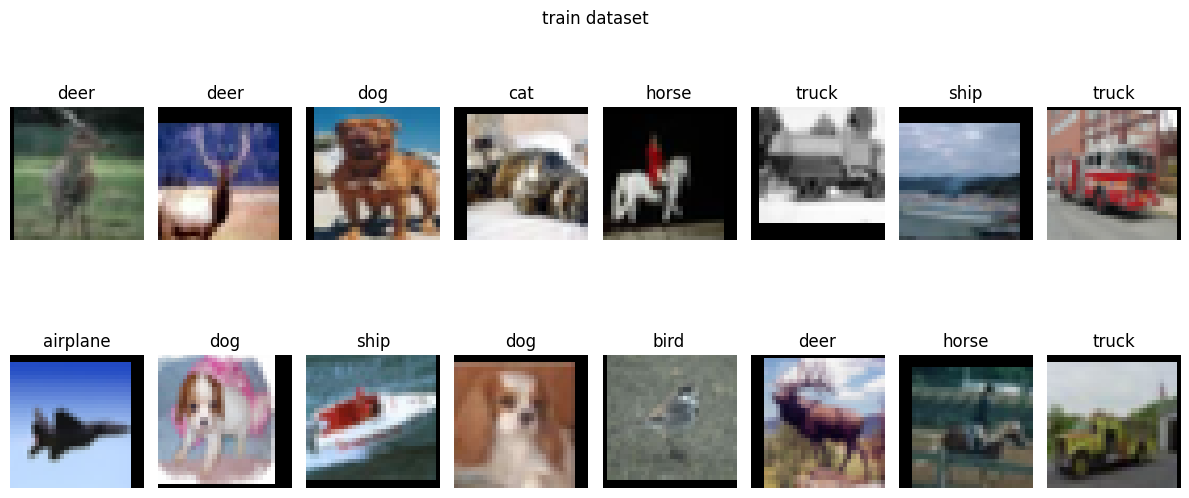

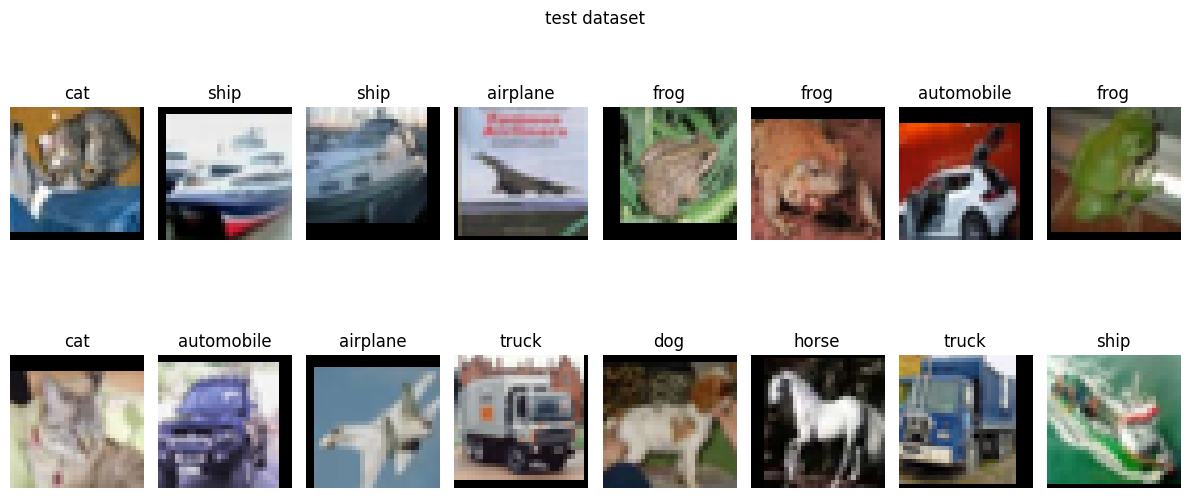

In [5]:
plot_cifar_loader(train_loader, 'train dataset')
plot_cifar_loader(test_loader, 'test dataset')

## VGG architecture

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim


class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## VGG training

In [7]:
model = VGG().to(device)

In [16]:
num_epochs = 50
learning_rate = 3e-4

In [ ]:
!pip install wandb
!wandb login

In [10]:
import wandb

In [ ]:
run = wandb.init(
    project="vgg-distill",
    config={
        "learning_rate": learning_rate,
        "epochs": num_epochs,
        "datase": "CIFAR-10"
    })

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in tqdm(enumerate(train_loader), total=total_step):
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        wandb.log({"loss": loss.item()})

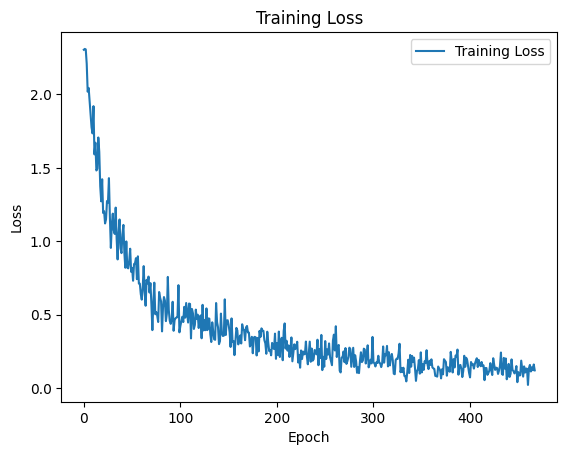

In [27]:
api = wandb.Api()
run = api.run(run.path)
history = run.history()

plt.plot(run.history()["loss"], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

## VGG eval

In [56]:
def eval_model(model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in tqdm(test_loader, total=len(test_loader), leave=False):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        return correct / total

In [57]:
teacher_model = model

In [58]:
acc = eval_model(teacher_model) * 100
print(f'Test Accuracy of the model on the {len(test_dataset)} test images: {acc:.2f}%')

Test Accuracy of the model on the 10000 test images: 86.27%


## Student architecture

In [74]:
class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.relu4 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        return x


## Student training

In [ ]:
run = wandb.init(
    project="vgg-distill",
    config={
        "learning_rate": learning_rate,
        "epochs": num_epochs,
        "datase": "CIFAR-10",
        "architecture": "student"
    })

In [75]:
student_model = StudentModel().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)


for epoch in range(num_epochs):
    for images, labels in tqdm(train_loader, total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)

        vgg_outputs = teacher_model(images)
        vgg_soft_targets = nn.functional.softmax(vgg_outputs / 3.0, dim=1)

        small_outputs = student_model(images)

        loss = criterion(small_outputs, vgg_soft_targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        wandb.log({'loss': loss.item()})

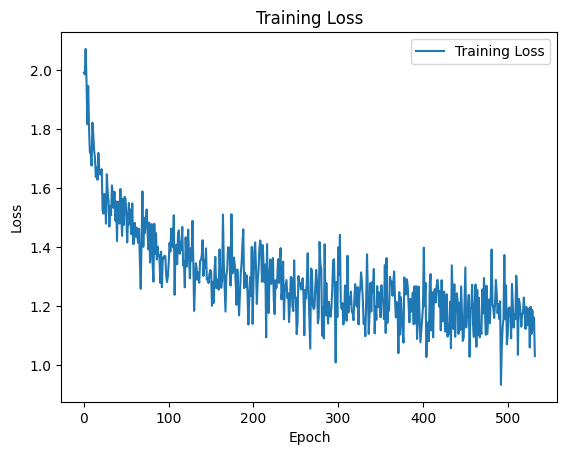

In [54]:
api = wandb.Api()
run = api.run(run.path)
history = run.history()

plt.plot(run.history()["loss"], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

## Student eval

In [59]:
acc = eval_model(student_model) * 100
print(f'Test Accuracy of the model on the {len(test_dataset)} test images: {acc:.2f}%')

Test Accuracy of the model on the 10000 test images: 69.13%


## Results

In [60]:
import humanize

def get_model_size(model):
    num_params = sum(p.numel() for p in model.parameters())
    size_in_bytes = num_params * 4  # Assuming float32 parameters
    size_str = humanize.naturalsize(size_in_bytes, binary=True)
    return size_str


In [61]:
get_model_size(teacher_model), get_model_size(student_model)

('125.3 MiB', '235.8 KiB')

In [62]:
eval_model(teacher_model), eval_model(student_model)

(0.8649, 0.6895)

In [76]:
%%time
_ = eval_model(teacher_model)

CPU times: user 7.31 s, sys: 56.7 ms, total: 7.36 s
Wall time: 8.6 s


In [77]:
%%time
_ = eval_model(student_model)

CPU times: user 4.93 s, sys: 28.9 ms, total: 4.96 s
Wall time: 5 s


В итоге обучили модель, которая занимает в 540 раз меньше места и делает предсказания быстрее

Точность упала с 86 до 69 процентов